In [1]:
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import branca.colormap as cm
import seaborn as sns
import folium

from sklearn.cluster import KMeans
from sklearn import preprocessing
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

data_path = os.path.abspath('.') + '/../data/'
train = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")
sample_submission = pd.read_csv(data_path + "sample_submission.csv")

In [2]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


数据量

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

数据类别

Features not used for indexing (latitude, longitude, year and week number) can be split into 8 groups: CarbonMonoxide, Cloud, Formaldehyde, NitrogenDioxide, Ozone, SulphurDioxide, UvAerosolIndex and UvAerosolLayerHeight.

In [4]:
{col.split('_')[0] for col in train.columns}

{'CarbonMonoxide',
 'Cloud',
 'Formaldehyde',
 'ID',
 'NitrogenDioxide',
 'Ozone',
 'SulphurDioxide',
 'UvAerosolIndex',
 'UvAerosolLayerHeight',
 'emission',
 'latitude',
 'longitude',
 'week',
 'year'}

年、周 特征分析

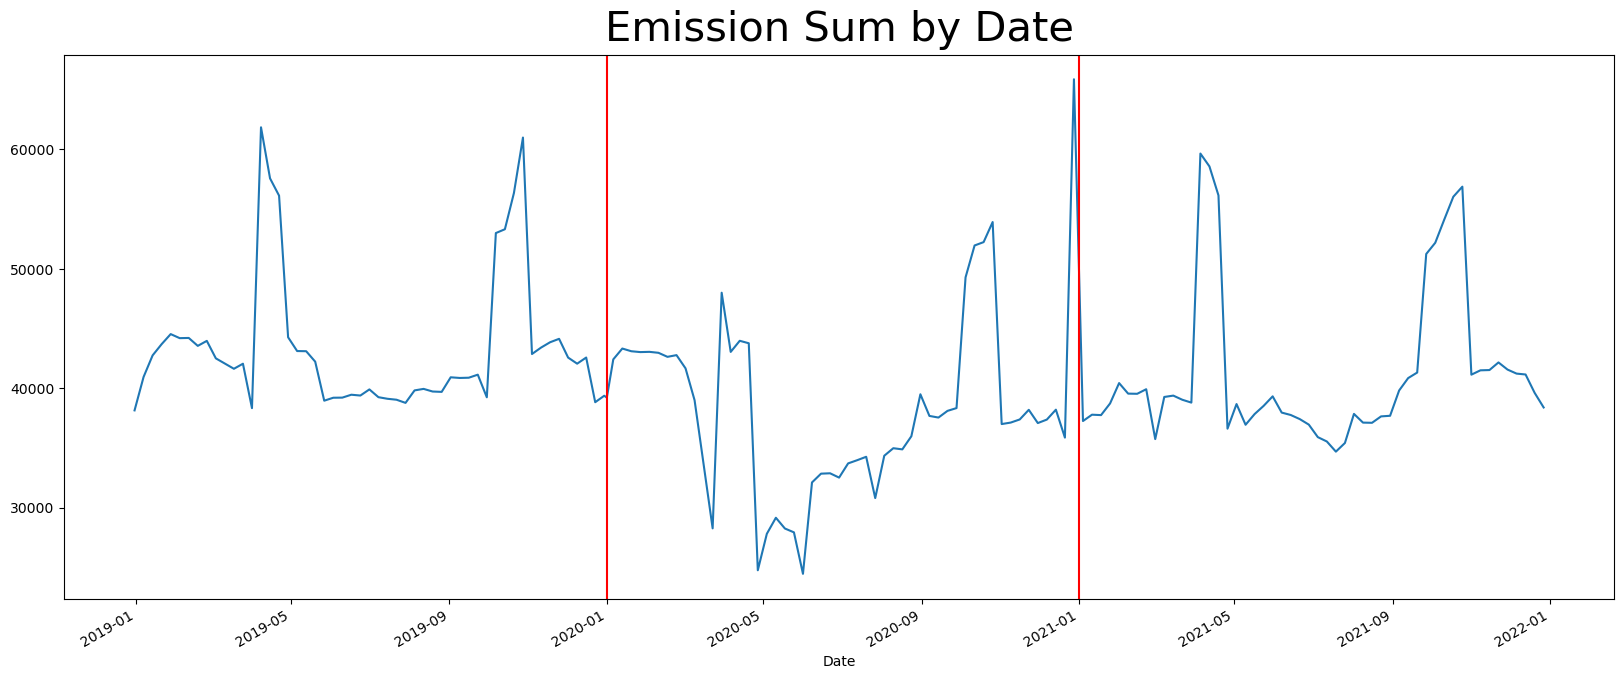

In [5]:
train_plot = train.copy(deep=True)
train_plot['date'] = pd.to_datetime(train_plot['year'].astype(str) + '-' + train_plot['week_no'].astype(str) + '-1', format='%Y-%W-%w')

train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 8), xlabel='Date')

# plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='red', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "-", color='red')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "-", color='red')

# plt.text(pd.Timestamp ('2020-05-30'), 60000, "Virus", size = 20)

plt.title('Emission Sum by Date', size=30, pad=10)
plt.show()

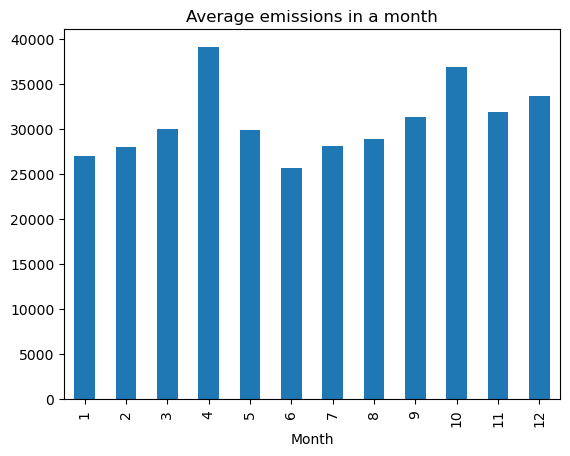

In [20]:
mask = train_plot['date'].dt.year != 2020
train_plot_no_2020 = train_plot[mask]

avg_month = train_plot_no_2020.groupby(train_plot['date'].dt.month)['emission'].sum() / 12
avg_month.plot(kind='bar', title='Average emissions in a month', xlabel='Month')

plt.show()

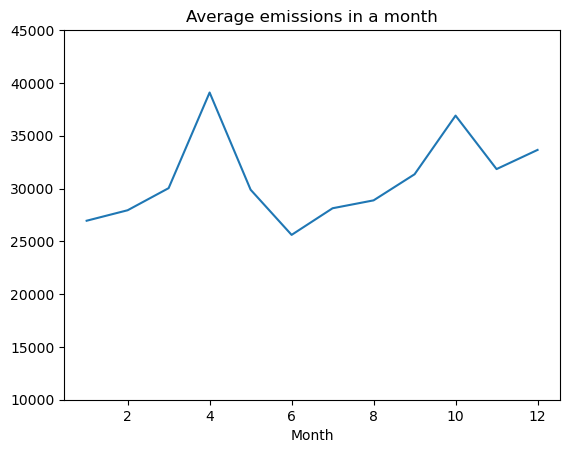

In [21]:
mask = train_plot['date'].dt.year != 2020
train_plot_no_2020 = train_plot[mask]

avg_month = train_plot_no_2020.groupby(train_plot_no_2020['date'].dt.month)['emission'].sum() / 12
avg_month.plot(title='Average emissions in a month', xlabel='Month')
plt.ylim(10000,45000)
plt.show()

In [23]:
# Group the train by 'latitude' and 'longitude' and compute the sum of the 'emission' values for each location
grouped = train.groupby(['latitude', 'longitude'])['emission'].sum().reset_index()

# Create a linear colormap that maps emission values to colors
colormap = cm.LinearColormap(['green', 'red'], vmin=0, vmax=10**5) # emssions above 10**5 will be labeled black

# Create a map centered at the mean latitude and longitude of points
m = folium.Map(location=[grouped['latitude'].mean(), grouped['longitude'].mean()])

# Add a circle marker to the map for each point in grouped dataframe
for _, row in grouped.iterrows():
    rows_emission = row['emission']
    color = 'white' if rows_emission == 0 else colormap(rows_emission) if rows_emission < 10**5 else 'darkred'
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=np.sqrt(row['emission'])*15,
        color=color,
        fill=True,
        fill_color= color
    ).add_to(m)

# Fit the map to the bounds of markers
m.fit_bounds(m.get_bounds())

# Display the map
m

<Axes: title={'center': 'Total emissions by location'}>

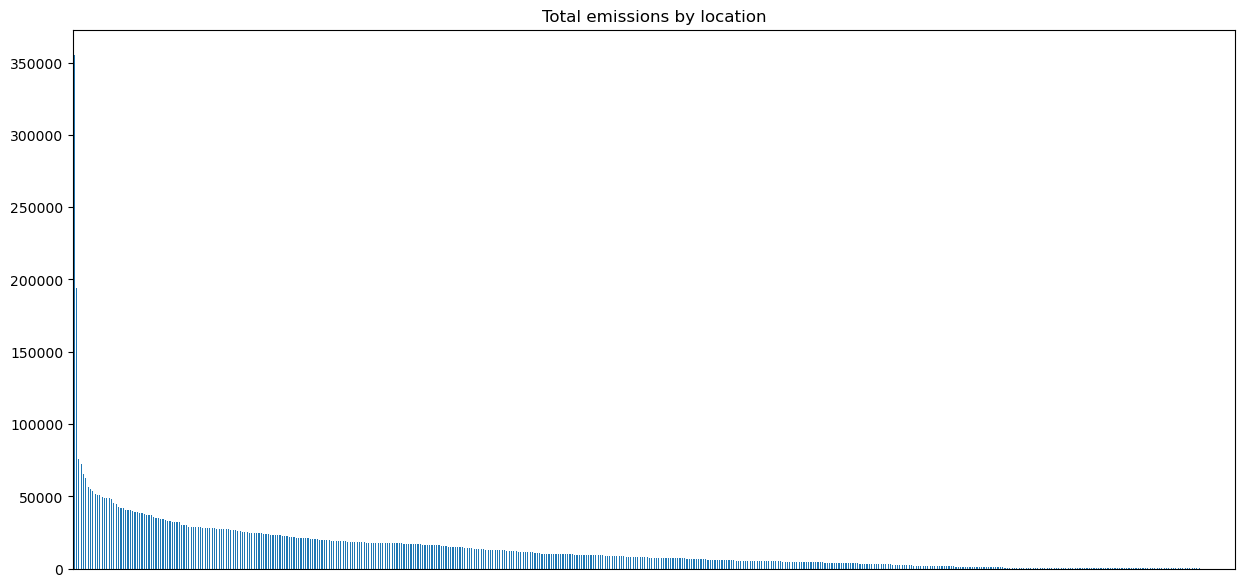

In [27]:
grouped['emission'].sort_values(ascending = False).plot(kind = 'bar', title = 'Total emissions by location', xticks = [], figsize=(15, 7))

In [8]:
train['week'] = (train['year'] - 2019) * 52 + train['week_no']
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,week
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,0
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,1
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381,2
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286,3
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317,4


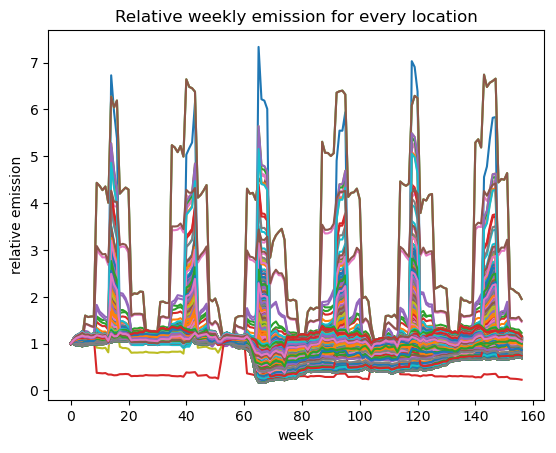

In [9]:
for ll in train[['latitude', 'longitude']].drop_duplicates().iterrows():
    time_series = train[(train.latitude == ll[1].latitude) & (train.longitude == ll[1].longitude)].groupby('week').emission.mean()
    time_series = time_series / time_series.loc[0]
    plt.plot(time_series.index, time_series)
plt.title('Relative weekly emission for every location')
plt.xlabel('week')
plt.ylabel('relative emission')

# plt.text(2022, 0.7, '?', fontsize=100, ha='center')
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

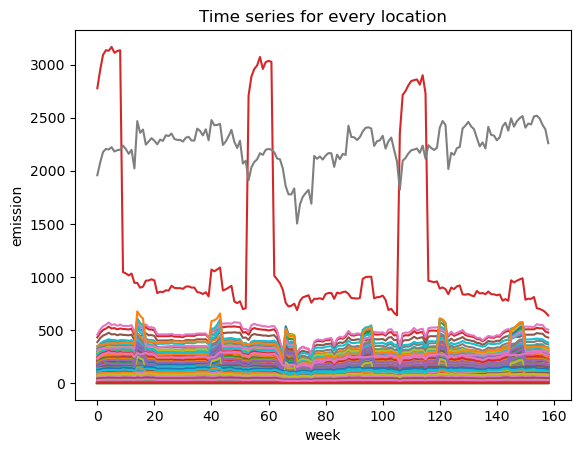

In [29]:
for ll in train[['latitude', 'longitude']].drop_duplicates().iterrows():
    time_series = train[(train.latitude == ll[1].latitude) & (train.longitude == ll[1].longitude)].emission
    plt.plot(range(len(time_series)), time_series)
plt.title('Time series for every location')
plt.xlabel('week')
plt.ylabel('emission')
plt.show()

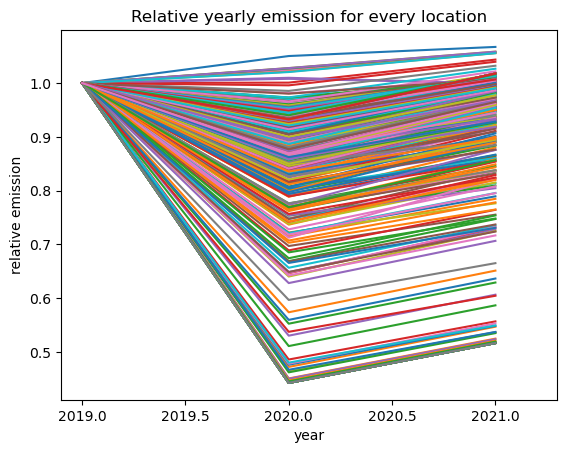

In [10]:
for ll in train[['latitude', 'longitude']].drop_duplicates().iterrows():
    time_series = train[(train.latitude == ll[1].latitude) & (train.longitude == ll[1].longitude)].groupby('year').emission.mean()
    time_series = time_series / time_series.loc[2019]
    plt.plot(time_series.index, time_series)
plt.title('Relative yearly emission for every location')
plt.xlabel('year')
plt.ylabel('relative emission')
plt.xlim(2018.9, 2021.3)
# plt.text(2022, 0.7, '?', fontsize=100, ha='center')
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()